In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import pickle

from tensorflow.keras.datasets import mnist

from sklearn.neighbors import KNeighborsClassifier

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.decomposition import PCA

# Load data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)


# Scale data and flat images
As our data represents gray-scale images, we will scale data between 0 and 1.

We will flat images in one dimensional array.

In [3]:
# Reshape
x_train_sc = x_train.reshape(60000, 784)
x_test_sc = x_test.reshape(10000, 784)

# Scale between 0 and 1
x_train_sc = x_train_sc / 255
x_test_sc = x_test_sc / 255

# Train model

In [4]:
# Create custom scorer for tuning
def f1_global(y_true, y_pred):
    precision_macro = precision_score(y_true, y_pred, average="macro")
    recall_macro = recall_score(y_true, y_pred, average="macro")
    return (2 * precision_macro * recall_macro) / (precision_macro + recall_macro)

f1_global_scorer = make_scorer(f1_global, greater_is_better=True)

In [5]:
m = KNeighborsClassifier(n_jobs=-1)

parameters = [{
    "n_neighbors": range(3, 25),
    "weights": ["uniform", "distance"]
}]

grid_search = GridSearchCV(m, parameters, verbose=3, scoring=f1_global_scorer)
grid_search.fit(x_train_sc, y_train)
model = grid_search.best_estimator_
score = grid_search.best_score_

Fitting 5 folds for each of 44 candidates, totalling 220 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  22.5s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  24.9s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  24.8s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  25.2s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  21.6s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  23.7s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  24.7s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  24.1s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  25.1s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  23.4s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  22.4s
[CV 2/5] END ....n_neighbors=4, weights=uniform

In [6]:
print("Mean cross-validated score of the best_estimator:", score)
print("\nModel optimal parameters".upper())
print("n_neighbors:", model.get_params()["n_neighbors"])
print("weights:", model.get_params()["weights"])

Mean cross-validated score of the best_estimator: 0.9715587909081341

MODEL OPTIMAL PARAMETERS
n_neighbors: 4
weights: distance


# Test model

In [7]:
predictions = model.predict(x_test_sc)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average="macro")
recall = recall_score(y_test, predictions, average="macro")
f1_macro = f1_score(y_test, predictions, average="macro")
f1_glob = (2 * precision * recall) / (precision + recall)

print("Accuracy score: {:.4f}%\nPrecision macro: {:.4f}%\nRecall macro: {:.4f}%".format(accuracy*100,precision*100,recall*100))
print("F1 macro: {:.4f}%\nF1 global: {:.4f}%".format(f1_macro*100, f1_glob*100))

Accuracy score: 97.1400%
Precision macro: 97.1560%
Recall macro: 97.1082%
F1 macro: 97.1224%
F1 global: 97.1321%


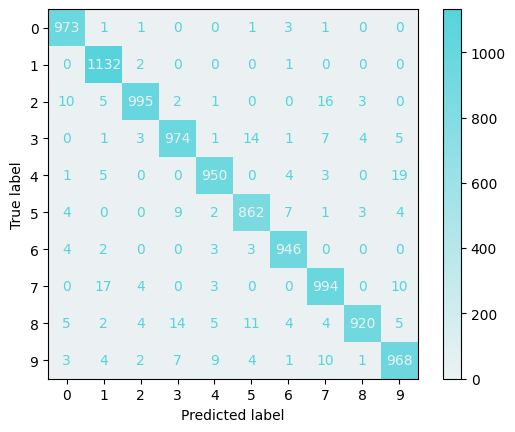

In [8]:
# Display confusion matrix
cmap = sns.light_palette(color=sns.color_palette("hls", 2)[1], as_cmap=True)
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                        y_pred=predictions,
                                        display_labels=model.classes_,
                                        cmap=cmap)
plt.show()

# PCA

# Load data

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)


# Train model with pipeline

In [10]:
# Reshape
x_train_pca = x_train.reshape(60000, 784)
x_test_pca = x_test.reshape(10000, 784)

# Create pipeline
knn = KNeighborsClassifier(n_jobs=-1)
scaler = StandardScaler()
pca = PCA(0.95)

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("knn", knn)])

parameters = {
    "knn__n_neighbors": range(3, 25),
    "knn__weights": ["uniform", "distance"]
}

grid_search = GridSearchCV(pipe, parameters, verbose=3, scoring=f1_global_scorer)
grid_search.fit(x_train_pca, y_train)

model = grid_search.best_estimator_
score = grid_search.best_score_

Fitting 5 folds for each of 44 candidates, totalling 220 fits
[CV 1/5] END knn__n_neighbors=3, knn__weights=uniform;, score=0.947 total time=   9.2s
[CV 2/5] END knn__n_neighbors=3, knn__weights=uniform;, score=0.946 total time=   9.2s
[CV 3/5] END knn__n_neighbors=3, knn__weights=uniform;, score=0.948 total time=   9.5s
[CV 4/5] END knn__n_neighbors=3, knn__weights=uniform;, score=0.941 total time=   9.5s
[CV 5/5] END knn__n_neighbors=3, knn__weights=uniform;, score=0.949 total time=   9.5s
[CV 1/5] END knn__n_neighbors=3, knn__weights=distance;, score=0.948 total time=   9.7s
[CV 2/5] END knn__n_neighbors=3, knn__weights=distance;, score=0.949 total time=   9.4s
[CV 3/5] END knn__n_neighbors=3, knn__weights=distance;, score=0.948 total time=   9.7s
[CV 4/5] END knn__n_neighbors=3, knn__weights=distance;, score=0.944 total time=   9.4s
[CV 5/5] END knn__n_neighbors=3, knn__weights=distance;, score=0.951 total time=   9.0s
[CV 1/5] END knn__n_neighbors=4, knn__weights=uniform;, score=0

In [11]:
print("Mean cross-validated score of the best_estimator:", score)
print("\nModel optimal parameters".upper())
print("n_neighbors:", model.get_params()["knn__n_neighbors"])
print("weights:", model.get_params()["knn__weights"])

Mean cross-validated score of the best_estimator: 0.949386342273191

MODEL OPTIMAL PARAMETERS
n_neighbors: 4
weights: distance


# Test

In [12]:
predictions = model.predict(x_test_pca)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average="macro")
recall = recall_score(y_test, predictions, average="macro")
f1_macro = f1_score(y_test, predictions, average="macro")
f1_glob = (2 * precision * recall) / (precision + recall)

print("Accuracy score: {:.4f}%\nPrecision macro: {:.4f}%\nRecall macro: {:.4f}%".format(accuracy*100,precision*100,recall*100))
print("F1 macro: {:.4f}%\nF1 global: {:.4f}%".format(f1_macro*100, f1_glob*100))

Accuracy score: 95.2900%
Precision macro: 95.2680%
Recall macro: 95.2303%
F1 macro: 95.2398%
F1 global: 95.2492%


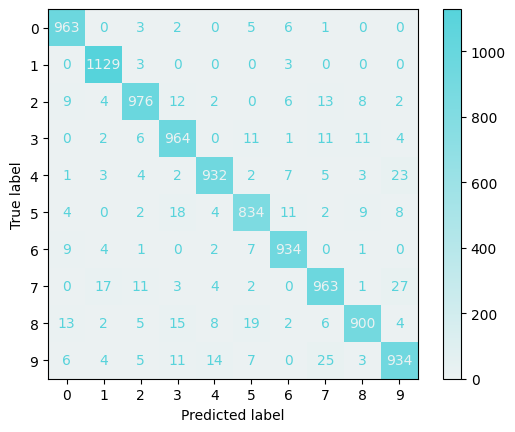

In [13]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                        y_pred=predictions,
                                        display_labels=model.classes_,
                                        cmap=cmap)
plt.show()